# ANALYSE PAR REGION #

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook
output_notebook()

Loading BokehJS ...

## CHOISIR UN NUMERO DE REGION A ANALYSER ##

In [2]:
#Choisir le numéro de région en se basant sur le tableau dans la partie import
region_num = 11

## IMPORT DATASETS ##

In [3]:
#dataframe pour visualisation des régions
reg_dic = pd.read_csv('dictionnaire_des_reg.csv')

#dictionnaire pour aider à l'appel de la fonction
reg_dict = dict(zip(reg_dic['REG'], reg_dic['REG_name']))
reg_dic

,REG,REG_name
0,82,Rhône-Alpes
1,22,Picardie
2,94,Corse
3,83,Auvergne
4,93,Provence-Alpes-Côte d'Azur
5,21,Champagne-Ardenne
6,73,Midi-Pyrénées
7,91,Languedoc-Roussillon
8,25,Basse-Normandie
9,54,Poitou-Charentes


In [4]:
ets = pd.read_csv('./data/base_etablissement_par_tranche_effectif.csv')


## CODE DE LA FONCTION ##

In [5]:
def ets_region(region_num, region_name):
    
    #création du dataframe filtré sur la région
    ets_reg = ets[ets['REG'] == region_num].reset_index(drop=True)
    
     
    print('Nombre de communes avec plus de 10.000 entreprises : {}'.format(len(ets_reg[ets_reg['E14TST'] > 10000])))    
    
    #Ajout d'une catégorisation en 4 quartiles pour le nombre d'établissements
    ets_reg['quartiles_ets'] = pd.qcut(ets_reg.E14TST, q=[0.0,0.25,0.5,0.75,1.0])

    #Tableau récapitulatif des ranges par quartile
    quartile_ranges = pd.DataFrame(ets_reg['quartiles_ets'].value_counts()).rename_axis('Range').sort_index()
 
    #Renomme les colonnes
    ets_reg.columns = ['CODGEO','LIBGEO', 'REG', 'DEP', 'Total_ets','0/NA', '1 à 5', '6 à 9', '10 à 19', '20 à 49', '50 à 99','100 à 199', '200 à 499', '500 et +','quartiles_ets']
    
    #Création d'un df melted par tailles
    ets_reg_melted = pd.melt(frame= ets_reg, id_vars=['CODGEO','LIBGEO','REG','DEP'], 
                         value_vars=['1 à 5', '6 à 9', '10 à 19', '20 à 49', '50 à 99', '100 à 199', '200 à 499', '500 et +'])
    
    #Division du dataset en 4 datasets, un par quartile, et melting des colonnes de tailles
    quartiles_df_list = []
    quartiles_df_melted_list = []
    for quartile in reversed(ets_reg['quartiles_ets'].unique()):
        #df par quartile
        quartile_df = ets_reg[ets_reg['quartiles_ets'] == quartile].reset_index(drop=True)
        quartiles_df_list.append(quartile_df)
        #df melted par quartile
        quartiles_df_melted_list.append(pd.melt(frame= quartile_df, id_vars=['CODGEO','LIBGEO','REG','DEP'], value_vars=['1 à 5', '6 à 9', '10 à 19', '20 à 49', '50 à 99', '100 à 199', '200 à 499', '500 et +']))
    
    print('Nombre de lignes de la df_reg : {}'.format(len(ets_reg)))

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX    PALETTE COULEURS        XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX    

    #Couleurs des graphiques Seaborn
    colors = ['#E5491F', '#4F0AEB', '#F0954E', '#F3BDA0', '#717ACE', '#64A8F7', '#C9C0B1', '#D9D9D9']
    sns.set_palette(sns.color_palette(colors))

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX          HIST              XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 

    #Création de la figure et titre principal
    fig, ax = plt.subplots(1,1, figsize=(16,8))
    fig.suptitle('Distribution du nombre d\'entreprises par commune de la région ' + region_name, fontsize=16)
    plt.subplots_adjust(hspace=0.3) 
    
    #bins
    bins = 50
    
    #Création du graphique pour la distribution de 0 à 500 ets
    ax.hist(ets_reg.Total_ets, 
                  range=(0,500), 
                  bins=bins,
                  edgecolor='black', 
                  linewidth=0.8, 
                  color='#64A8F7'
                  )
    
    #Gestion des axes
    #x = np.arange(0, int(np.round(quartile_ranges.index[2].right,0)), int(np.round(quartile_ranges.index[2].right,0) /bins))
    x = np.arange(0,500,50)
    labels = [i for i in x]
    ax.set_xticks(x)
    ax.set_xticklabels(labels=labels)
    
    #Optimisation du graphique
    ax.set_xlabel('Nombre d\'entreprises')
    ax.set_ylabel('Nombre de communes')
    ax.set_title('Distribution des communes domiciliant de 0 à 500 entreprises', ha='right')
    ax.grid(visible=False)
    ax.set_facecolor('#EEEDED')

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX         MINI HIST              XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 

    #Afin que la fonction puisse fonctionner avec les régions qui n'ont pas de communes > 500 ets,
    #Une condition d'affichage du 3ème graphique
    if len(ets_reg[ets_reg.Total_ets > 500]) >0:
    
        #Création d'un mini graphique pour la distribution de 500 à 5000 ets
        ax2 = plt.axes([0.44, 0.63, 0.45, 0.2])
        ax2.hist(ets_reg.Total_ets, 
                 bins= 20,
                 range = (500, 10000),
                 edgecolor='black',
                 linewidth=0.8,
                 alpha=0.8
                )
        

        
        #Gestion des axes
        ax2.set_title('de 500 à 10.000 entreprises')
        x2 = np.linspace(500,10000, 20)
        labels2 = ["{:,.1f}".format(i / 1000) for i in x2]
        ax2.set_xticks(x2)
        ax2.set_xticklabels(labels=labels2)
        ax2.set_xlabel('en milliers')

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX         BARH PLOT              XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
        
    #Afin que la fonction puisse fonctionner avec les régions qui n'ont pas de communes > 10K ets,
    #Une condition d'affichage du 3ème graphique
    if len(ets_reg[ets_reg.Total_ets > 10000]) > 0:
        
        #Création d'un dataframe
        ets_10000 = ets_reg[ets_reg.Total_ets > 10000].reset_index(drop=True).sort_values(by='Total_ets', ascending=False)
        len_ets_1000 = len(ets_10000)
        #Création d'un mini graphique pour les éventuels outliers
        ax3 = plt.axes([0.69, 0.39, 0.2, 0.15])
        barh = ax3.barh(y=ets_10000.LIBGEO, 
                width=ets_10000.Total_ets,
                height=0.8, 
                alpha=0.8,
                edgecolor='black')

        #Gestion des axes
        ax3.invert_yaxis()
        ax3.tick_params(axis='x', bottom=False, labelbottom=False)
        ax3.set_xlim(ets_10000.Total_ets.min() * 0.8, ets_10000.Total_ets.max() * 1.2)
        labels3 = ["{:,.1f}".format(int(i) / 1000) for i in barh.datavalues]
        ax3.bar_label(barh, labels=labels3, padding=5)
        
        #Optimisation du graphique
        ax3.set_title('> 10.000 entreprises')
        ax3.set_xlabel('en milliers')
        
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX         PIE CHART              XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
    
    #Création figure nombre d'entreprises par département
    fig, ax = plt.subplots(1,2, figsize=(16,8))
    fig.suptitle('Répartition des entreprises par départements de la région ' + region_name, fontsize=16)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.subplot(121)
    x = ets_reg.groupby('DEP').agg({'Total_ets': 'sum'})
    labels = ['DEP ' +str(i) for i in x.index]
    ax1 = plt.pie(x=x.Total_ets, labels=labels, autopct='%.1f%%' )
    plt.title('Répartition de '+"{:,.0f}".format(x.Total_ets.sum())+ ' entreprises par département')
    #ax.bar(x=ets_reg.DEP, height=ets_reg.Total_ets)

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX         STRIP PLOT              XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
    plt.subplot(122)
    ax2 = sns.stripplot(data=ets_reg[ets_reg.Total_ets < 10000],  x='DEP', y='Total_ets')
    ax2.set_ylabel('Nombre d\'entreprises')
    ax2.set_xlabel('Départements')
    ax2.set_title('Total entreprises par commune et par département \n Chaque point représente une commune.')

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX         BAR PLOTS              XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 
    #Création de la figure, titre principal et ajustements
    fig, ax = plt.subplots(2,2, figsize=(16,16))
    fig.suptitle('Analyse des tailles d\'entreprises \nde la région' + region_name +' par quantile', fontsize=16)
    plt.subplots_adjust(hspace=0.3)    
    

    for i, j in enumerate(quartiles_df_melted_list):
        plt.subplot(2,2,i+1)
        
        #Stockage des modes
        labels = j.variable.unique()
        
        #Nombre de ticks relatifs aux modes
        x = range(0, len(labels))
        
        #Création du graphique
        ax = sns.barplot(data = j, x='variable', y='value', ci=None, estimator=sum)
        
        #Optimisation du graphique
        ax.set_facecolor('#EEEDED')
        ax.set_title('Quantile ' + str(i+1) +' : intervalle de '+ "{:,.0f}".format(int(np.round(quartile_ranges.index[i].left,0))) + ' à ' + "{:,.0f}".format(int(np.round(quartile_ranges.index[i].right,0))) + ' entreprises par commune', fontweight='black' )
        ax.set_xlabel('Tailles (nombre de salariés)')
        ax.set_ylabel('Nombre d\'entreprises')
        ax.set_xticks(x)
        ax.set_xticklabels(labels= labels, rotation=45)
        ax.yaxis.set_major_formatter(lambda x, pos: str(int(x)))
        container_ax = ax.containers[0]
        container_labels = ["{:,.0f}".format(i) for i in container_ax.datavalues]
        ax.bar_label(container_ax, labels=container_labels)
        t = plt.text(.45, .98, ha='left', va='top', transform=ax.transAxes,
             s='Total de '+ "{:,.0f}".format(j.value.sum()) 
             + ' entreprises \nde tailles connues pour ' 
             +  "{:,.0f}".format(quartiles_df_list[i]['Total_ets'].sum()) + '\nentreprises recensées soit '
             + "{:0.1f}".format(quartiles_df_list[i]['0/NA'].sum() / quartiles_df_list[i]['Total_ets'].sum() *100)+'% \nde taille 0 ou inconnue. Le '
             + 'quantile  \nregroupe ' + str(len(quartiles_df_list[i])) + ' communes.')
        plt.setp(t, fontsize=12, style='italic')
    plt.show()



## APPEL DE LA FONCTION ##

Nombre de communes avec plus de 10.000 entreprises : 3
Nombre de lignes de la df_reg : 1281


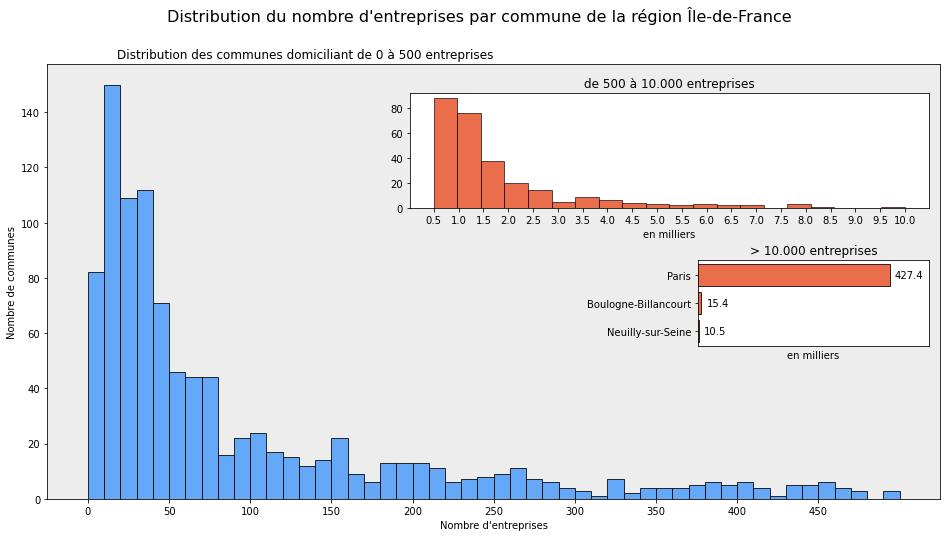

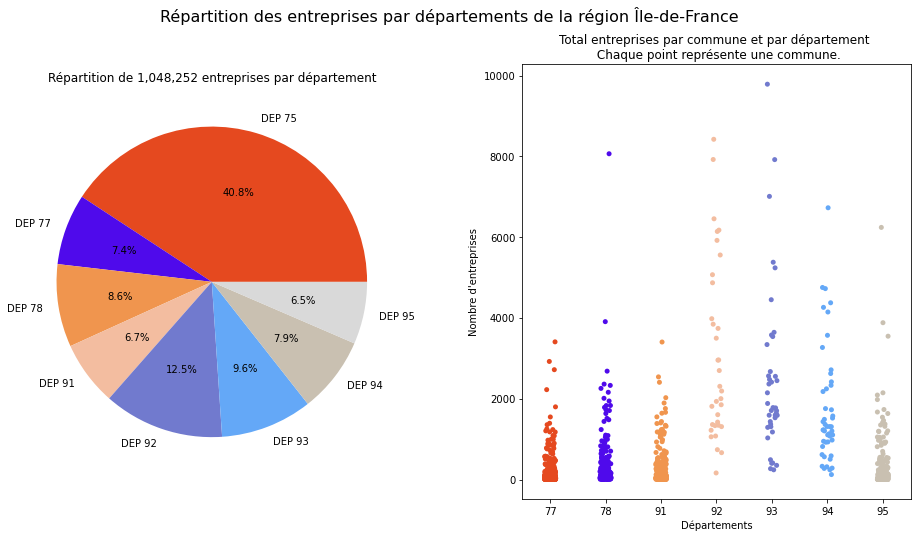

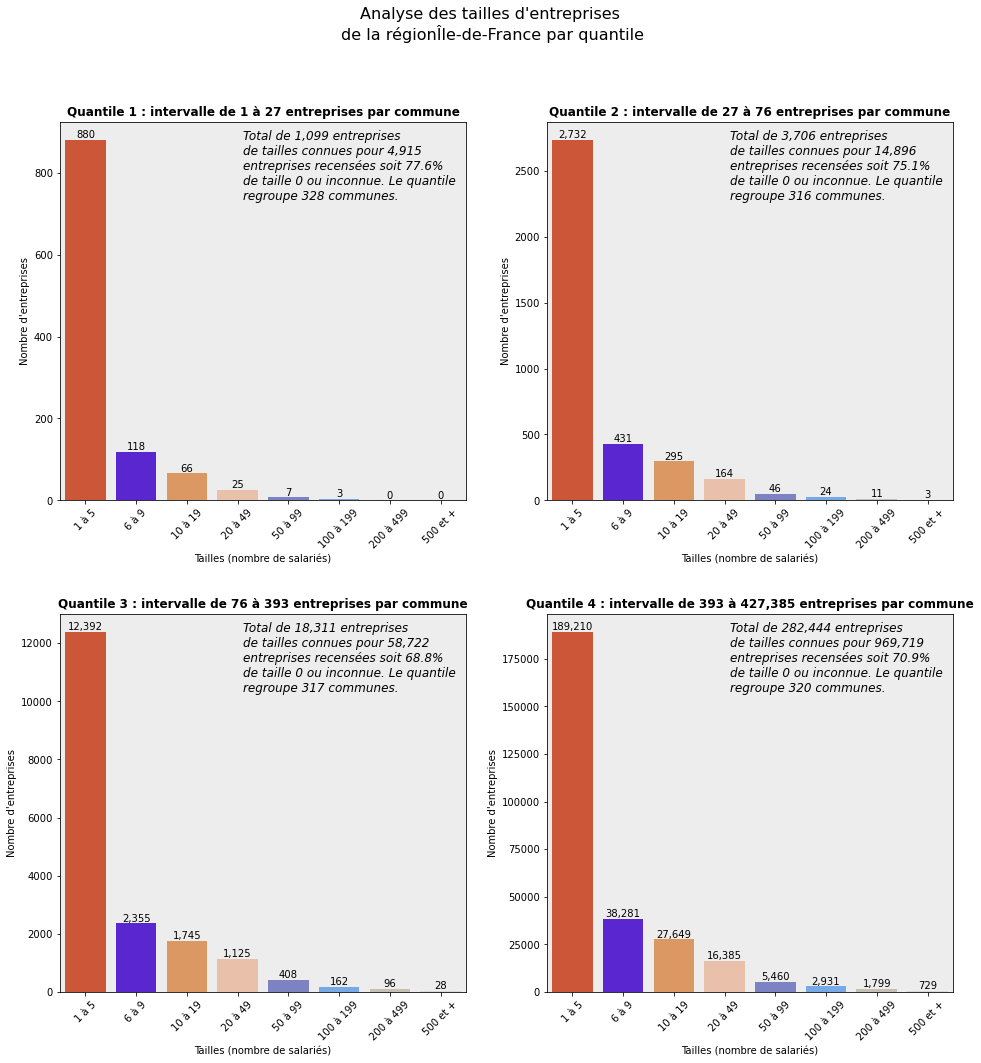

In [6]:

region_name = reg_dict[region_num]
ets_region(region_num, region_name)
